In [3]:
pip install torch transformers pandas openpyxl xlsxwriter


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 3.5 MB/s eta 0:00:00


In [5]:
import pandas as pd
import torch
import numpy as np
from transformers import AutoModel, AutoTokenizer

# Load the CodeT5+ model and tokenizer
checkpoint = "Salesforce/codet5p-110m-embedding"
device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained(checkpoint, trust_remote_code=True)
model = AutoModel.from_pretrained(checkpoint, trust_remote_code=True).to(device)

# Load the Excel file from the specified path
df = pd.read_excel("/content/c.xlsx")
print("Data loaded successfully:")
print(df.head())  # Display the first few rows of the DataFrame

# Function to encode data in batches
def encode_data_batch(df, model, tokenizer, device, start_row, end_row):
    embeddings = []
    for i in range(start_row, end_row):
        code = df['C'][i]  # Use the 'java' column
        inputs = tokenizer.encode(code, return_tensors="pt", max_length=512, truncation=True).to(device)
        with torch.no_grad():
            embedding = model(inputs)[0].cpu().numpy()  # Get fixed-size embeddings
        embeddings.append(embedding)
    return embeddings

# Process the data in batches
batch_size = 300
all_embeddings = []

start_row = 0
while start_row < len(df):
    end_row = min(start_row + batch_size, len(df))
    embeddings_batch = encode_data_batch(df, model, tokenizer, device, start_row, end_row)
    all_embeddings.extend(embeddings_batch)
    start_row = end_row

# Convert to numpy array and reshape if necessary
embeddings_array = np.vstack(all_embeddings)

# Create DataFrame from embeddings
embedding_columns = [f'c_codeonly_embedding_{i}' for i in range(embeddings_array.shape[1])]
embeddings_df = pd.DataFrame(embeddings_array, columns=embedding_columns)

# Save embeddings to Excel with a neatly formatted sheet
output_path = "/content/c_codepnly_embeddings.xlsx"
with pd.ExcelWriter(output_path, engine='xlsxwriter') as writer:
    embeddings_df.to_excel(writer, index=False, sheet_name="Embeddings")
    workbook = writer.book
    worksheet = writer.sheets["Embeddings"]

    # Set column widths for neat formatting
    for i, column in enumerate(embeddings_df.columns):
        max_len = max(embeddings_df[column].astype(str).map(len).max(), len(column))
        worksheet.set_column(i, i, max_len + 2)  # Adjust the padding as needed

print(f"Embeddings have been saved to {output_path}")

Data loaded successfully:
                                                   C
0  #include <stdio.h>\n#include <string.h>\n#incl...
1  #include <stdio.h>\n#include <string.h>\n#incl...
2  #include <stdio.h>\n#include <string.h>\n#incl...
3  #include <stdio.h>\n#include <string.h>\n#incl...
4  #include <stdio.h>\n#include <string.h>\n\nvoi...
Embeddings have been saved to /content/c_codepnly_embeddings.xlsx


In [15]:
# Step 1: Install required libraries
!pip install hdbscan umap-learn openpyxl

import pandas as pd
import umap

# Step 2: Load the embeddings
embeddings_df = pd.read_excel("/content/c_codepnly_embeddings.xlsx")

# Step 3: Select the embedding data
# Adjust this if you want to select specific columns
embedding_data = embeddings_df.iloc[:, :].values  # Use all embedding columns

# Step 4: Apply UMAP for dimensionality reduction to 2 components
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=6, random_state=42)
umap_embeddings = umap_model.fit_transform(embedding_data)

# Step 5: Create a DataFrame from UMAP embeddings
umap_df = pd.DataFrame(umap_embeddings, columns=['UMAP_1', 'UMAP_2','UMAP_3','UMAP_4','UMAP_5','UMAP_6'])

# Step 6: Save the UMAP results to a new Excel file
output_path = "/content/C_umap6_embeddings.xlsx"
umap_df.to_excel(output_path, index=False)

print(f"UMAP embeddings have been saved to {output_path}")


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP embeddings have been saved to /content/C_umap6_embeddings.xlsx


In [7]:
import pandas as pd
from sklearn.cluster import DBSCAN
import numpy as np

# Load the Excel file containing the embeddings
file_path = "/content/C_umap_embeddings.xlsx"
df = pd.read_excel(file_path)

# Convert DataFrame to numpy array for DBSCAN
embeddings = df.values

# Apply DBSCAN clustering
# You can adjust eps based on your data characteristics
dbscan = DBSCAN(eps=0.5, min_samples=5)  # min_samples can be set to a low value
cluster_labels = dbscan.fit_predict(embeddings)

# Find the number of clusters formed (excluding noise)
num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)

print(f"Number of clusters formed: {num_clusters}")

Number of clusters formed: 17


In [8]:
import pandas as pd
import hdbscan
import numpy as np

# Load the Excel file containing the embeddings
file_path = "/content/C_umap_embeddings.xlsx"
df = pd.read_excel(file_path)

# Assuming the embeddings are in columns and are numeric
# Convert DataFrame to numpy array for HDBSCAN
embeddings = df.values

# Apply HDBSCAN clustering
clusterer = hdbscan.HDBSCAN(min_cluster_size=5)  # You can adjust min_cluster_size as needed
cluster_labels = clusterer.fit_predict(embeddings)

# Find the number of clusters formed (excluding noise)
num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)

print(f"Number of clusters formed: {num_clusters}")

Number of clusters formed: 7


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


DBSCAN (n_components=3): Number of clusters = 16
HDBSCAN (n_components=3): Number of clusters = 25


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


DBSCAN (n_components=4): Number of clusters = 18
HDBSCAN (n_components=4): Number of clusters = 23


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


DBSCAN (n_components=5): Number of clusters = 16
HDBSCAN (n_components=5): Number of clusters = 21


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


DBSCAN (n_components=6): Number of clusters = 16
HDBSCAN (n_components=6): Number of clusters = 22


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


DBSCAN (n_components=7): Number of clusters = 16
HDBSCAN (n_components=7): Number of clusters = 21


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


DBSCAN (n_components=8): Number of clusters = 16
HDBSCAN (n_components=8): Number of clusters = 24


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


DBSCAN (n_components=9): Number of clusters = 14
HDBSCAN (n_components=9): Number of clusters = 20


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


DBSCAN (n_components=10): Number of clusters = 15
HDBSCAN (n_components=10): Number of clusters = 18


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


DBSCAN (n_components=11): Number of clusters = 16
HDBSCAN (n_components=11): Number of clusters = 19


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


DBSCAN (n_components=12): Number of clusters = 17
HDBSCAN (n_components=12): Number of clusters = 22


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


DBSCAN (n_components=13): Number of clusters = 17
HDBSCAN (n_components=13): Number of clusters = 21


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


DBSCAN (n_components=14): Number of clusters = 16
HDBSCAN (n_components=14): Number of clusters = 20


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


DBSCAN (n_components=15): Number of clusters = 15
HDBSCAN (n_components=15): Number of clusters = 22
DBSCAN: Maximum clusters 18 at n_components=4
HDBSCAN: Maximum clusters 25 at n_components=3


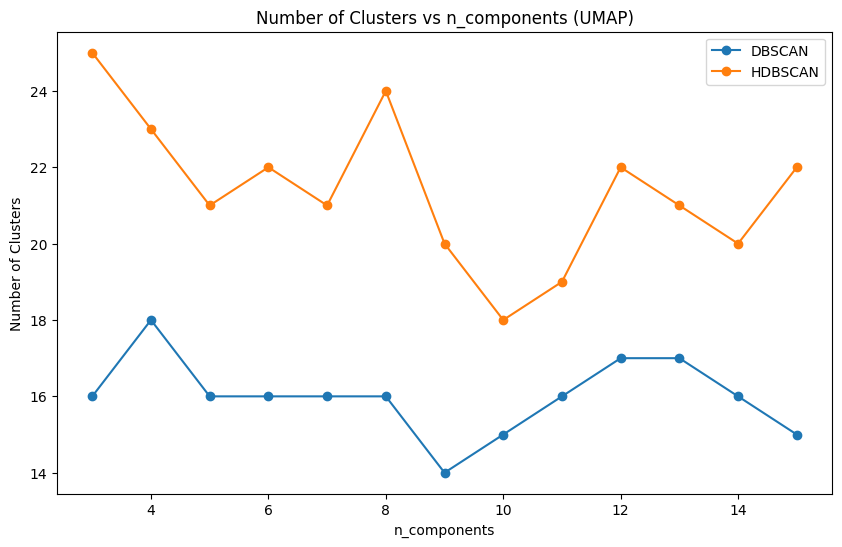

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from umap import UMAP
from sklearn.cluster import DBSCAN
import hdbscan

# Load the saved UMAP embeddings from Excel
input_path = "/content/C_umap_embeddings.xlsx"
embeddings_df = pd.read_excel(input_path)
embeddings = embeddings_df.values

# Store results for plotting
results = []

# Function to print the number of clusters
def print_num_clusters(labels, model_name, n_components):
    num_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # Exclude noise for DBSCAN/HDBSCAN
    print(f"{model_name} (n_components={n_components}): Number of clusters = {num_clusters}")
    return [model_name, n_components, num_clusters]

# Iterate over n_components from 3 to 15
for n_components in range(3, 16):
    # Apply UMAP dimensionality reduction
    umap_reducer = UMAP(n_components=n_components, random_state=42)
    reduced_data = umap_reducer.fit_transform(embeddings)

    # Apply DBSCAN
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    dbscan_labels = dbscan.fit_predict(reduced_data)
    dbscan_result = print_num_clusters(dbscan_labels, 'DBSCAN', n_components)
    results.append(dbscan_result)

    # Apply HDBSCAN
    hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=1)
    hdbscan_labels = hdbscan_clusterer.fit_predict(reduced_data)
    hdbscan_result = print_num_clusters(hdbscan_labels, 'HDBSCAN', n_components)
    results.append(hdbscan_result)

# Convert results to DataFrame for further analysis
results_df = pd.DataFrame(results, columns=['Model', 'n_components', 'Number of Clusters'])

# Identify the n_components where the maximum number of clusters was formed
max_dbscan_clusters = results_df[results_df['Model'] == 'DBSCAN']['Number of Clusters'].max()
best_dbscan_n = results_df[(results_df['Model'] == 'DBSCAN') &
                           (results_df['Number of Clusters'] == max_dbscan_clusters)]['n_components'].values[0]

max_hdbscan_clusters = results_df[results_df['Model'] == 'HDBSCAN']['Number of Clusters'].max()
best_hdbscan_n = results_df[(results_df['Model'] == 'HDBSCAN') &
                            (results_df['Number of Clusters'] == max_hdbscan_clusters)]['n_components'].values[0]

print(f"DBSCAN: Maximum clusters {max_dbscan_clusters} at n_components={best_dbscan_n}")
print(f"HDBSCAN: Maximum clusters {max_hdbscan_clusters} at n_components={best_hdbscan_n}")

# Plotting the results
fig, ax = plt.subplots(figsize=(10, 6))
for model_name in ['DBSCAN', 'HDBSCAN']:
    model_data = results_df[results_df['Model'] == model_name]
    ax.plot(
        model_data['n_components'],
        model_data['Number of Clusters'],
        marker='o',
        label=model_name
    )

plt.title("Number of Clusters vs n_components (UMAP)")
plt.xlabel("n_components")
plt.ylabel("Number of Clusters")
plt.legend(loc='best')
plt.show()


In [11]:
import pandas as pd
import hdbscan

# Load the saved embeddings from Excel
input_path = "/content/C_umap3_embeddings.xlsx"
embeddings_df = pd.read_excel(input_path)
embeddings = embeddings_df.values

# Apply HDBSCAN clustering
hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=1)
labels = hdbscan_clusterer.fit_predict(embeddings)

# Calculate the number of clusters (ignoring noise points labeled as -1)
num_clusters = len(set(labels)) - (1 if -1 in labels else 0)

# Print the number of clusters formed
print(f"Number of clusters formed: {num_clusters}")


Number of clusters formed: 24


In [ ]:
/content/C_umap4_embeddings.xlsx

In [14]:
import pandas as pd
import hdbscan

# Load the saved embeddings from Excel
input_path = "/content/C_umap4_embeddings.xlsx"
embeddings_df = pd.read_excel(input_path)
embeddings = embeddings_df.values

# Apply HDBSCAN clustering
hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=1)
labels = hdbscan_clusterer.fit_predict(embeddings)

# Calculate the number of clusters (ignoring noise points labeled as -1)
num_clusters = len(set(labels)) - (1 if -1 in labels else 0)

# Print the number of clusters formed
print(f"Number of clusters formed: {num_clusters}")

Number of clusters formed: 25


In [16]:
import pandas as pd
import hdbscan

# Load the saved embeddings from Excel
input_path = "/content/C_umap6_embeddings.xlsx"
embeddings_df = pd.read_excel(input_path)
embeddings = embeddings_df.values

# Apply HDBSCAN clustering
hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=1)
labels = hdbscan_clusterer.fit_predict(embeddings)

# Calculate the number of clusters (ignoring noise points labeled as -1)
num_clusters = len(set(labels)) - (1 if -1 in labels else 0)

# Print the number of clusters formed
print(f"Number of clusters formed: {num_clusters}")

Number of clusters formed: 25


In [20]:
import pandas as pd
from sklearn.cluster import DBSCAN
import numpy as np

# Load the Excel file containing the embeddings
file_path = "/content/C_umap6_embeddings.xlsx"
df = pd.read_excel(file_path)

# Convert DataFrame to numpy array for DBSCAN
embeddings = df.values

# Apply DBSCAN clustering
# You can adjust eps based on your data characteristics
dbscan = DBSCAN(eps=0.5, min_samples=5)  # min_samples can be set to a low value
cluster_labels = dbscan.fit_predict(embeddings)

# Find the number of clusters formed (excluding noise)
num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)

print(f"Number of clusters formed: {num_clusters}")

Number of clusters formed: 25
